In [1]:
# pylint: disable=unused-import
import networkx as nx
import numpy as np
import pandas as pd
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt
from networkx import betweenness_centrality

import sys
sys.path.append('..')

from model import pca_kmeans
from utils import compute_ppr
from utils import evaluation
from utils import load_data
from utils import load_or_dump
from utils import symmetrically_normalize_adj
from pymetis import part_graph

sns.set_theme(color_codes=True)

datasets = [
    'Flickr',
    'ACM',
    'BlogCatalog',
    'Cora',
    'Citeseer',
    'Pubmed',
    'CoraFull',
    'arxiv',
    'products',
    'Reddit',
]
# datasets = ['Flickr', 'ACM', 'BlogCatalog']
# datasets = ['Cora', 'Citeseer', 'Pubmed', 'CoraFull']
# datasets = ['products', 'arxiv', 'mag', 'proteins', 'arxiv']

def cal_adj_sym(_adj_sl):
    return symmetrically_normalize_adj(_adj_sl).toarray()


def cal_ppr(_adj_np):
    return compute_ppr(_adj_np)


def cal_node_betweenness_centrality(_graph):
    return betweenness_centrality(
        nx.Graph(_graph.cpu().to_networkx(node_attrs=['feat'])))

cython version 1
imported cython version: 1


# 类间节点及其边的分布情况

In [7]:
datasets = ['ACM', 'BlogCatalog', 'Flickr']
for ds in datasets:
    graph, label, n_lbs = load_data(ds)
    features = graph.ndata["feat"]
    edges = graph.edges()
    adj = graph.adj()
    n_nodes = graph.num_nodes()
    u, v = edges[0].numpy(), edges[1].numpy()

    intra_class_edge_cnt = 0
    sl_intra_class_edge_cnt = 0
    intra_class_sym_cnt = 0
    intra_class_ppr = 0

    lbl_np = label.numpy()
    label_dicts = {l: np.nonzero(lbl_np == l)[0] for l in np.unique(lbl_np)}

    adj_np = adj.to_dense().numpy()
    adj_sl = np.array(adj_np + sp.eye(adj.shape[0]))

    adj_sym = load_or_dump(f"{ds}_adj_sym", cal_adj_sym, {'_adj_sl': adj_sl})
    ppr = load_or_dump(f"{ds}_ppr", cal_ppr, {'_adj_np': adj_np})
    node_betweenness_centrality = load_or_dump(
        f"{ds}_betweenness",
        cal_node_betweenness_centrality,
        {'_graph': graph},
    )

    # NOTE: inter_class_cnt

    inter_class_edge_idx = np.nonzero(lbl_np[u] != lbl_np[v])[0]
    # 边界节点 idx
    inter_class_node_idx = list(
        set(list(u[inter_class_edge_idx]) + list(v[inter_class_edge_idx])))

    # 类内边计数
    for i in range(n_nodes):
        intra_class_edge_cnt += adj_np[i][label_dicts[lbl_np[i]]].sum()

    # 边界节点 adj
    adj_inter_class_node = adj_np[inter_class_node_idx]
    adj_inter_class_nodes_intra_weights = 0

    for i, node in enumerate(inter_class_node_idx):
        adj_inter_class_nodes_intra_weights += adj_inter_class_node[i][
            label_dicts[lbl_np[node]]].sum()

    print(
        f"\n类内边计数: \t\t{intra_class_edge_cnt}",
        f"\n类内边占比: \t\t{intra_class_edge_cnt / adj_np.sum()}",
        f"\n边界节点的类内边权重和: \t{adj_inter_class_nodes_intra_weights}",
        f"\n边界节点的类内边的权重和/边界节点所有边的权重和: \t\
            {adj_inter_class_nodes_intra_weights / adj_inter_class_node.sum()}"
    )

    for i in range(n_nodes):
        sl_intra_class_edge_cnt += adj_sl[i][label_dicts[lbl_np[i]]].sum()

    adj_sl_inter_class_node = adj_sl[inter_class_node_idx]
    adj_sl_inter_class_nodes_intra_weights = 0

    for i, node in enumerate(inter_class_node_idx):
        adj_sl_inter_class_nodes_intra_weights += adj_sl_inter_class_node[i][
            label_dicts[lbl_np[node]]].sum()

    print(
        f"\n加自环 类内边计数: \t\t{sl_intra_class_edge_cnt}",
        f"\n加自环 类内边占比: \t\t{sl_intra_class_edge_cnt / adj_sl.sum()}",
        f"\n加自环 边界节点的类内边权重和: \t{adj_sl_inter_class_nodes_intra_weights}",
        f"\n加自环 边界节点的类内边的权重和/边界节点所有边的权重和: \t\
            {adj_sl_inter_class_nodes_intra_weights / adj_sl_inter_class_node.sum()}"
    )

    for i in range(n_nodes):
        intra_class_sym_cnt += adj_sym[i][label_dicts[lbl_np[i]]].sum()

    adj_sym_inter_class_node = adj_sym[inter_class_node_idx]
    ajd_sym_inter_class_nodes_intra_weights = 0

    for i, node in enumerate(inter_class_node_idx):
        ajd_sym_inter_class_nodes_intra_weights += adj_sym_inter_class_node[i][
            label_dicts[lbl_np[node]]].sum()

    print(
        f"\n对称标准化 类内边计数: \t\t{intra_class_sym_cnt}",
        f"\n对称标准化 类内边占比: \t\t{intra_class_sym_cnt / adj_sym.sum()}",
        f"\n对称标准化 边界节点的类内边权重和: \t{ajd_sym_inter_class_nodes_intra_weights}",
        f"\n对称标准化 边界节点的类内边的权重和/边界节点所有边的权重和: \t\
            {ajd_sym_inter_class_nodes_intra_weights / adj_sym_inter_class_node.sum()}"
    )

    for i in range(n_nodes):
        intra_class_ppr += ppr[i][label_dicts[lbl_np[i]]].sum()

    ppr_inter_class_node = ppr[inter_class_node_idx]
    ppr_inter_class_nodes_intra_weights = 0

    for i, node in enumerate(inter_class_node_idx):
        ppr_inter_class_nodes_intra_weights += ppr_inter_class_node[i][
            label_dicts[lbl_np[node]]].sum()

    print(
        f"\nPPR 类内边计数: \t\t{intra_class_ppr}",
        f"\nPPR 类内边占比: \t\t{intra_class_ppr / ppr.sum()}",
        f"\nPPR 边界节点的类内边权重和: \t{ppr_inter_class_nodes_intra_weights}",
        f"\nPPR 边界节点的类内边的权重和: \t\
            {ppr_inter_class_nodes_intra_weights / ppr_inter_class_node.sum()}"
    )


  DGL dataset
  NumNodes: 3025
  NumEdges: 26256
  NumFeats: 1870
  NumClasses: 3
'ACM_adj_sym' dumped before. Load from file.
'ACM_ppr' dumped before. Load from file.
'ACM_betweenness' dumped before. Load from file.

类内边计数: 		21550.0 
类内边占比: 		0.8207647775746496 
边界节点的类内边权重和: 	12342.0 
边界节点的类内边的权重和/边界节点所有边的权重和: 	            0.7239558892538714

加自环 类内边计数: 		24575.0 
加自环 类内边占比: 		0.8392814453058297 
加自环 边界节点的类内边权重和: 	13245.0 
加自环 边界节点的类内边的权重和/边界节点所有边的权重和: 	            0.7378419029580525

对称标准化 类内边计数: 		2691.1260127961864 
对称标准化 类内边占比: 		0.9187806092231816 
对称标准化 边界节点的类内边权重和: 	671.2073111314686 
对称标准化 边界节点的类内边的权重和/边界节点所有边的权重和: 	            0.738320282786177

PPR 类内边计数: 		2622.9774849616356 
PPR 类内边占比: 		0.9069424366623973 
PPR 边界节点的类内边权重和: 	688.3692106795503 
PPR 边界节点的类内边的权重和: 	            0.7549253522807499

  DGL dataset
  NumNodes: 5196
  NumEdges: 343486
  NumFeats: 8189
  NumClasses: 6
'BlogCatalog_adj_sym' dumped before. Load from file.
'BlogCatalog_ppr' dumped before. Load from f

# 可视化 betweenness 分布


  DGL dataset
  NumNodes: 3025
  NumEdges: 26256
  NumFeats: 1870
  NumClasses: 3
'ACM_adj_sym' dumped before. Load from file.
'ACM_ppr' dumped before. Load from file.
'ACM_betweenness' dumped before. Load from file.


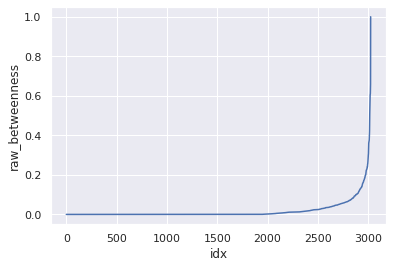

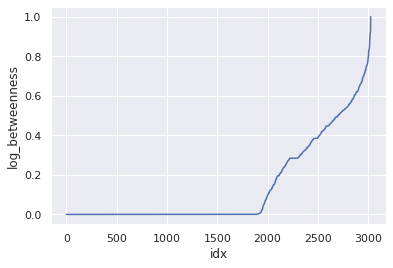


  DGL dataset
  NumNodes: 5196
  NumEdges: 343486
  NumFeats: 8189
  NumClasses: 6
'BlogCatalog_adj_sym' dumped before. Load from file.
'BlogCatalog_ppr' dumped before. Load from file.
'BlogCatalog_betweenness' dumped before. Load from file.


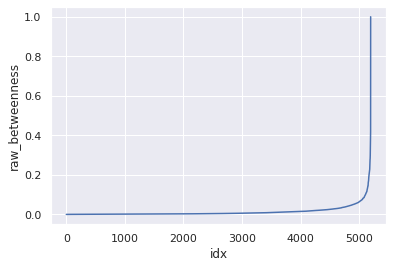

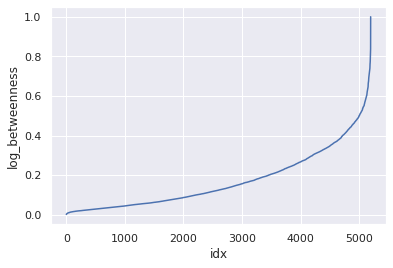


  DGL dataset
  NumNodes: 7575
  NumEdges: 479476
  NumFeats: 12047
  NumClasses: 9
'Flickr_adj_sym' dumped before. Load from file.
'Flickr_ppr' dumped before. Load from file.
'Flickr_betweenness' dumped before. Load from file.


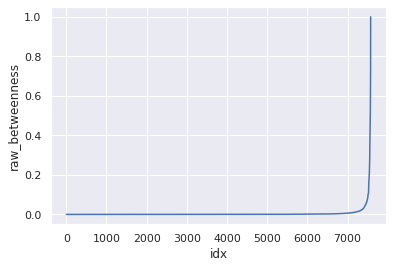

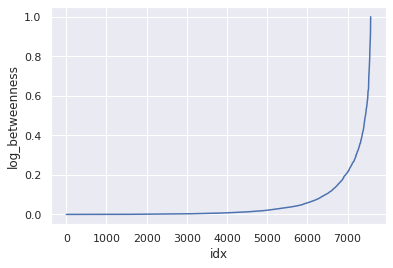

<Figure size 432x288 with 0 Axes>

In [6]:
datasets = ['ACM', 'BlogCatalog', 'Flickr']
for ds in datasets:
    graph, label, n_lbs = load_data(ds)
    features = graph.ndata["feat"]
    edges = graph.edges()
    adj = graph.adj()
    n_nodes = graph.num_nodes()
    u, v = edges[0].numpy(), edges[1].numpy()

    intra_class_edge_cnt = 0
    sl_intra_class_edge_cnt = 0
    intra_class_sym_cnt = 0
    intra_class_ppr = 0

    lbl_np = label.numpy()
    label_dicts = {l: np.nonzero(lbl_np == l)[0] for l in np.unique(lbl_np)}

    # NOTE: get adj_sl, adj_sym, betweenness and ppr

    adj_np = adj.to_dense().numpy()
    adj_sl = np.array(adj_np + sp.eye(adj.shape[0]))

    adj_sym = load_or_dump(f"{ds}_adj_sym", cal_adj_sym, {'_adj_sl': adj_sl})
    ppr = load_or_dump(f"{ds}_ppr", cal_ppr, {'_adj_np': adj_np})
    node_betweenness_centrality = load_or_dump(
        f"{ds}_betweenness",
        cal_node_betweenness_centrality,
        {'_graph': graph},
    )

    raw_betweenness = np.array(list(
        node_betweenness_centrality.values())) * 10000
    log_betweenness = np.log(1 + raw_betweenness)

    plt.xlabel('idx')
    plt.ylabel('raw_betweenness')
    plt.plot(
        list(range(len(raw_betweenness))),
        np.sort(raw_betweenness / max(raw_betweenness)),
    )
    plt.show()
    # plt.savefig(f'./results/tmp/{ds}_raw_betweenness.png')
    plt.clf()

    plt.xlabel('idx')
    plt.ylabel('log_betweenness')
    plt.plot(
        list(range(len(log_betweenness))),
        np.sort(log_betweenness / max(log_betweenness)),
    )
    plt.show()
    # plt.savefig(f'./results/tmp/{ds}_log_betweenness.png')
    plt.clf()

# Structure partition VS Attribute clustering VS Label

In [2]:
datasets = ['Cora', 'Citeseer', 'Pubmed', 'BlogCatalog', 'Flickr']
for ds in datasets:
    graph, label, n_lbs = load_data(ds)
    features = graph.ndata["feat"]
    edges = graph.edges()
    adj = graph.adj()
    n_nodes = graph.num_nodes()
    u, v = edges[0].numpy(), edges[1].numpy()

    intra_class_edge_cnt = 0
    sl_intra_class_edge_cnt = 0
    intra_class_sym_cnt = 0
    intra_class_ppr = 0

    lbl_np = label.numpy()
    label_dicts = {l: np.nonzero(lbl_np == l)[0] for l in np.unique(lbl_np)}

    adj_list = [[] for _ in range(n_nodes)]
    for i, j in zip(u, v):
        if i == j:
            continue
        adj_list[i].append(j)

    cutcount, ss_labels = part_graph(nparts=n_lbs, adjacency=adj_list)
    ss_labels = np.array(ss_labels)
    (
        ARI_score,
        NMI_score,
        AMI_score,
        ACC_score,
        Micro_F1_score,
        Macro_F1_score,
    ) = evaluation(label, ss_labels)

    print(f"{ds} / partition: \t\
            {(ARI_score,NMI_score,AMI_score,ACC_score,Micro_F1_score,Macro_F1_score)}"
          )

    res = pca_kmeans(
        X=features,
        n_components=128,
        n_clusters=n_lbs,
    )

    (
        ARI_score,
        NMI_score,
        AMI_score,
        ACC_score,
        Micro_F1_score,
        Macro_F1_score,
    ) = evaluation(label, res)

    print(
        f"{ds} / kmeans: \t\t\t{(ARI_score,NMI_score,AMI_score,ACC_score,Micro_F1_score,Macro_F1_score)}"
    )

    (
        ARI_score,
        NMI_score,
        AMI_score,
        ACC_score,
        Micro_F1_score,
        Macro_F1_score,
    ) = evaluation(ss_labels, res)

    print(
        f"{ds} / k&p: \t\t\t{(ARI_score,NMI_score,AMI_score,ACC_score,Micro_F1_score,Macro_F1_score)}"
    )



  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


Cora / partition: 	            (0.29744037605936446, 0.3907695465031348, 0.5808714918759232, 0.5808714918759232, 0.5766052029380886)


2022-09-20 01:14:34 WARNING version.py: 19 The OGB package is out of date. Your version is 1.3.3, while the latest version is 1.3.4.


Cora / kmeans: 			(0.03069367467760467, 0.08011270086252006, 0.276218611521418, 0.276218611521418, 0.20386857824269525)
Cora / k&p: 			(0.021030285832936698, 0.0425073599020637, 0.22636632200886264, 0.22636632200886264, 0.18695833230857248)


  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


Citeseer / partition: 	            (0.11156162841680538, 0.13729525014683486, 0.33844304177938084, 0.33844304177938084, 0.32520085056416587)
Citeseer / kmeans: 			(0.15066119411363715, 0.1958202128392021, 0.42530808536218817, 0.42530808536218817, 0.4075857446616978)
Citeseer / k&p: 			(0.04428306423946829, 0.07705198559763682, 0.29335737902013825, 0.29335737902013825, 0.29681191797808365)


  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.